# Milestone Project 1: Food Vision Big

## Check GPU

In [4]:
# If the following line doesn't output "Tesla T4", you can try getting access to
# another GPU by going to Runtime -> Factory Reset Runtime -> "Yes" and then
# re-running this cell.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c27b941d-139b-f1b3-bb6b-7a00e7fe7637)
GPU 1: Tesla T4 (UUID: GPU-d20d4b1e-2a1a-9db1-1fe4-81893f0b9e5e)


## Get helper functions

In [5]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-01-14 05:46:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-14 05:46:03 (90.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [6]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview



In [7]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [8]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:

* Class names

* The shape of our input data (image tensors)

* The datatype of our input data

* What the labels look like (e.g. are they one-hot encoded or are they label encoded)

* Do the labels match up with the class names?

In [10]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [11]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [12]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
# output info about our training sample
for image, label in train_one_sample:
    print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 64
  Class name (str form): miso_soup
  


In [14]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 43,  89, 125],
        [ 52,  96, 131],
        [ 85, 128, 162],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       [[ 42,  88, 124],
        [ 53,  97, 132],
        [ 92, 135, 169],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       [[ 45,  89, 124],
        [ 52,  96, 131],
        [ 92, 135, 169],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       ...,

       [[ 91,  99,  86],
        [ 89,  97,  84],
        [ 88,  94,  82],
        ...,
        [ 37,  44,  50],
        [ 34,  41,  47],
        [ 31,  38,  44]],

       [[ 91,  99,  86],
        [ 90,  98,  85],
        [ 88,  96,  83],
        ...,
        [ 38,  43,  47],
        [ 35,  40,  44],
        [ 33,  38,  42]],

       [[ 93, 101,  88],
        [ 93, 101,  88],
        [ 89,  97,  84],
        ...,
        [ 37,  42,  4

In [15]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

(-0.5, 511.5, 511.5, -0.5)

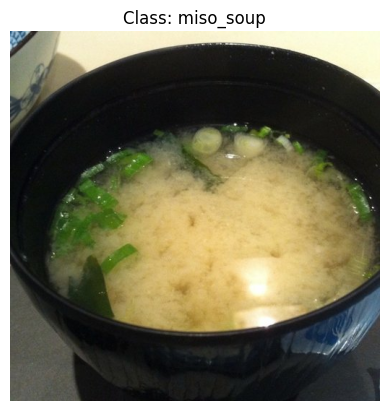

In [16]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(f"Class: {class_names[label.numpy()]}")
plt.axis(False)

### Create preprocessing functions for our data

In [17]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label

In [18]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 43  89 125]
  [ 52  96 131]
  [ 85 128 162]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 [[ 42  88 124]
  [ 53  97 132]
  [ 92 135 169]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[ 48.969387  93.68367  129.04082 ]
  [124.78572  164.07144  195.28572 ]
  [125.37245  158.94388  183.5153  ]
  ...
  [251.78574  254.78574  223.78574 ]
  [251.       254.       223.      ]
  [250.       253.       222.      ]]

 [[ 65.28572  108.688774 143.09183 ]
  [129.93878  169.09184  200.17348 ]
  [ 79.61224  115.04081  140.88266 ]
  ...
  [251.78574  254.78574  223.78574 ]
  [251.       254.       223.      ]
  [250.       253.       222.      ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

In [19]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:

* TensorBoard callback to log training results (so we can visualize them later if need be)

* ModelCheckpoint callback to save our model's progress after feature extraction

In [21]:
from helper_functions import create_tensorboard_callback

In [22]:
# Create checkpoint callback
checkpoint_path = "101_classes_100_percent_data_model_checkpoint.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         verbose=0)

## Setup mixed precision training

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [23]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Set global data policy to mixed precision

In [24]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [248]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [249]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Checking layer dtype policies (are we using mixed precision?)

In [250]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d_8 True float32 <DTypePolicy "mixed_float16">
dense_8 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [251]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_8 False float32 <DTypePolicy "mixed_float16">
rescaling_16 False float32 <DTypePolicy "mixed_float16">
normalization_8 False float32 <DTypePolicy "mixed_float16">
rescaling_17 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_

In [252]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:

1. Build a feature extraction model (train a couple output layers with base layers frozen)

2. Fine-tune some of the frozen layers

In [253]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20250114-121428
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 101s 35ms/step - accuracy: 0.4355 - loss: 2.4559 - val_accuracy: 0.6610 - val_loss: 1.2985
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6525 - val_loss: 1.3105
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.6307 - loss: 1.4485 - val_accuracy: 0.6817 - val_loss: 1.1852


In [254]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.6796 - loss: 1.1889


[1.184460163116455, 0.6848316788673401]

## Save the whole model to file

In [53]:
!mkdir "models"

mkdir: cannot create directory ‘models’: File exists


In [255]:
model.save("models/101_food_classes_100_percent_saved_big_dog_model.keras")

In [256]:
# Load model previously saved above
loaded_model = tf.keras.models.load_model("models/101_food_classes_100_percent_saved_big_dog_model.keras")

In [257]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_8 True float32 <DTypePolicy "mixed_float16">
rescaling_16 False float32 <DTypePolicy "mixed_float16">
normalization_8 False float32 <DTypePolicy "mixed_float16">
rescaling_17 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_f

In [258]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.6808 - loss: 1.1811


[1.176939606666565, 0.6837623715400696]

In [259]:
results_feature_extract_model

[1.184460163116455, 0.6848316788673401]

## Preparing our model's layers for fine-tuning

In [260]:
loaded_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,437,720 (16.93 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [261]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 20
# for layer in base_model.layers[:-20]:
#     layer.trainable = False

In [262]:
# Are any of the layers in our model frozen?
for layer in model.layers:
    model.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 True float32 <DTypePolicy "mixed_float16">
global_average_pooling2d_8 True float32 <DTypePolicy "mixed_float16">
dense_8 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [263]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [264]:
for num, layer in enumerate(model.layers[1].layers):
  print(num, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_layer_8 True float32 <DTypePolicy "mixed_float16">
1 rescaling_16 True float32 <DTypePolicy "mixed_float16">
2 normalization_8 True float32 <DTypePolicy "mixed_float16">
3 rescaling_17 True float32 <DTypePolicy "mixed_float16">
4 stem_conv_pad True float32 <DTypePolicy "mixed_float16">
5 stem_conv True float32 <DTypePolicy "mixed_float16">
6 stem_bn True float32 <DTypePolicy "mixed_float16">
7 stem_activation True float32 <DTypePolicy "mixed_float16">
8 block1a_dwconv True float32 <DTypePolicy "mixed_float16">
9 block1a_bn True float32 <DTypePolicy "mixed_float16">
10 block1a_activation True float32 <DTypePolicy "mixed_float16">
11 block1a_se_squeeze True float32 <DTypePolicy "mixed_float16">
12 block1a_se_reshape True float32 <DTypePolicy "mixed_float16">
13 block1a_se_reduce True float32 <DTypePolicy "mixed_float16">
14 block1a_se_expand True float32 <DTypePolicy "mixed_float16">
15 block1a_se_excite True float32 <DTypePolicy "mixed_float16">
16 block1a_project_conv True floa

In [265]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)

In [266]:
# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "101_classes_100_percent_data_fine_tune_model_checkpoint.keras"
fine_tuned_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor="val_loss",
                                                         save_best_only=True,
                                                         verbose=0)

In [267]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                  factor=0.2, # Multiply the learning rate by 0.2 (reduce by 5x)
                                                  patience=2,
                                                  verbose=1,
                                                  min_lr=1e-8)

In [268]:
# Fit the fine-tuned model with callbacks
history_101_food_classes_fine_tuned_100_epochs = model.fit(train_data,
                                                     epochs=20,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[fine_tuned_model_checkpoint, earlystopping_callback, reduce_lr])

Epoch 1/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 305s 101ms/step - accuracy: 0.6165 - loss: 1.5114 - val_accuracy: 0.7971 - val_loss: 0.7374 - learning_rate: 1.0000e-04
Epoch 2/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7940 - val_loss: 0.7490 - learning_rate: 1.0000e-04
Epoch 3/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 207s 87ms/step - accuracy: 0.7861 - loss: 0.7986 - val_accuracy: 0.8151 - val_loss: 0.6435 - learning_rate: 1.0000e-04
Epoch 4/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8239 - val_loss: 0.6461 - learning_rate: 1.0000e-04
Epoch 5/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 209s 88ms/step - accuracy: 0.8437 - loss: 0.5818 - val_accuracy: 0.8294 - val_loss: 0.6246 - learning_rate: 1.0000e-04
Epoch 6/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8167 - val_loss: 0.6483 - learning_rate: 1.0000e-04
Epoch 7/20
2367/23

In [271]:
fine_tuned_model_results = model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8364 - loss: 0.5988


In [274]:
# Save the fine-tuned model
model.save("models/101_food_classes_100_percent_saved_fine_tuned_big_dog_model.keras")

In [275]:
loaded_fine_tuned_model = tf.keras.models.load_model("models/101_food_classes_100_percent_saved_fine_tuned_big_dog_model.keras")

In [277]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,452,816 (47.50 MB)

 Trainable params: 4,136,929 (15.78 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,273,864 (31.56 MB)

## EfficientNetB4

In [278]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_B4 = tf.keras.Model(inputs, outputs)

# Compile the model
model_B4.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [279]:
# Check the dtype_policy attributes of layers in our model
for layer in model_B4.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb4 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d_9 True float32 <DTypePolicy "mixed_float16">
dense_9 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [280]:
# Check the dtype_policy attributes of layers in the base model
for layer in model_B4.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)    

input_layer_9 False float32 <DTypePolicy "mixed_float16">
rescaling_18 False float32 <DTypePolicy "mixed_float16">
normalization_9 False float32 <DTypePolicy "mixed_float16">
rescaling_19 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_

In [281]:
# Create checkpoint callback
checkpoint_path = "101_classes_100_percent_data_model_checkpoint_b4.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         verbose=0)

In [282]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract_b4 = model_B4.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[model_checkpoint])

Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 213s 72ms/step - accuracy: 0.4311 - loss: 2.4324 - val_accuracy: 0.6419 - val_loss: 1.3778
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6385 - val_loss: 1.3751
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 142s 60ms/step - accuracy: 0.6052 - loss: 1.5321 - val_accuracy: 0.6573 - val_loss: 1.2661


In [283]:
# Evaluate model_B4 on test dataset
model_b4_result = model_B4.evaluate(test_data)
model_b4_result

790/790 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step - accuracy: 0.6646 - loss: 1.2699


[1.2728501558303833, 0.6646732687950134]

In [284]:
base_model.trainable = True

In [285]:
# Are any of the layers in our model frozen?
for layer in model_B4.layers:
    model_B4.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb4 True float32 <DTypePolicy "mixed_float16">
global_average_pooling2d_9 True float32 <DTypePolicy "mixed_float16">
dense_9 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [286]:
# Compile the model
model_B4.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [287]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)

In [288]:
# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "101_classes_100_percent_data_fine_tune_model_checkpoint_B4.keras"
fine_tuned_model_checkpoint_B4 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor="val_loss",
                                                         save_best_only=True,
                                                         verbose=0)

In [289]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                  factor=0.2, # Multiply the learning rate by 0.2 (reduce by 5x)
                                                  patience=2,
                                                  verbose=1,
                                                  min_lr=1e-8)

In [290]:
# Fit the fine-tuned model with callbacks
history_101_food_classes_fine_tuned_100_epochs_B4 = model_B4.fit(train_data,
                                                     epochs=20,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[fine_tuned_model_checkpoint_B4, earlystopping_callback, reduce_lr])

Epoch 1/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 754s 248ms/step - accuracy: 0.5875 - loss: 1.6363 - val_accuracy: 0.8144 - val_loss: 0.6751 - learning_rate: 1.0000e-04
Epoch 2/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8069 - val_loss: 0.6837 - learning_rate: 1.0000e-04
Epoch 3/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 500s 210ms/step - accuracy: 0.8266 - loss: 0.6385 - val_accuracy: 0.8136 - val_loss: 0.6337 - learning_rate: 1.0000e-04
Epoch 4/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8199 - val_loss: 0.6460 - learning_rate: 1.0000e-04
Epoch 5/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 502s 211ms/step - accuracy: 0.9059 - loss: 0.3401 - val_accuracy: 0.8292 - val_loss: 0.6297 - learning_rate: 1.0000e-04
Epoch 6/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8228 - val_loss: 0.6579 - learning_rate: 1.0000e-04
Epoch 7/20
2368/

In [291]:
model_B4_results = model_B4.evaluate(test_data)
model_B4_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.8487 - loss: 0.6244


[0.6352185606956482, 0.8479207754135132]